**Student Insight Engine: End-to-End Analytics & ML Pipeline**

**Track:** Education & Predictive Analytics

**Pipeline Flow:** Data Cleaning -> 21-Formula Feature Engineering -> RFE Feature Selection -> EDA -> Multi-Model Benchmarking -> Linear Benchmarking -> K-Means Persona Clustering.

In [2]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm catboost -q
print("Libraries installed.")

Libraries installed.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import warnings

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")

**PHASE 1: Data Cleaning**

In [4]:
raw_path = 'Student_data.csv'

if not os.path.exists(raw_path):
    # Fallback to 'data/' folder if notebook is run in a different directory level
    raw_path = 'data/Student_data.csv'

df_raw = pd.read_csv(raw_path)
print(f"Original rows: {len(df_raw)}")
print("Missing values before cleaning:")
print(df_raw.isnull().sum()[df_raw.isnull().sum() > 0])

Original rows: 6607
Missing values before cleaning:
Teacher_Quality             78
Parental_Education_Level    90
Distance_from_Home          67
dtype: int64


In [5]:
df_cleaned = df_raw.copy()

cat_cols = [
    'Parental_Involvement', 'Access_to_Resources', 'Extracurricular_Activities',
    'Motivation_Level', 'Internet_Access', 'Family_Income', 'Teacher_Quality',
    'School_Type', 'Peer_Influence', 'Learning_Disabilities',
    'Parental_Education_Level', 'Distance_from_Home', 'Gender'
]

num_cols = [
    'Hours_Studied', 'Attendance', 'Sleep_Hours', 'Previous_Scores',
    'Tutoring_Sessions', 'Physical_Activity', 'Exam_Score'
]

for col in cat_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

In [6]:
for col in num_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
        df_cleaned[col] = df_cleaned[col].astype(int)

In [7]:
df_cleaned['Attendance'] = df_cleaned['Attendance'].clip(0, 100)
df_cleaned['Hours_Studied'] = df_cleaned['Hours_Studied'].clip(0, 50)
df_cleaned['Sleep_Hours'] = df_cleaned['Sleep_Hours'].clip(3, 12)
df_cleaned['Tutoring_Sessions'] = df_cleaned['Tutoring_Sessions'].clip(0, 10)
df_cleaned['Physical_Activity'] = df_cleaned['Physical_Activity'].clip(0, 7)
df_cleaned['Exam_Score'] = df_cleaned['Exam_Score'].clip(0, 100)
df_cleaned['Previous_Scores'] = df_cleaned['Previous_Scores'].clip(0, 100)

df_cleaned = df_cleaned.drop_duplicates()

In [9]:
classes = [f"Class {i}" for i in range(1, 11)]
df_cleaned['Class'] = [random.choice(classes) for _ in range(len(df_cleaned))]

if 'Tutoring_Sessions' in df_cleaned.columns:
    students_with_zero_tutoring = df_cleaned[df_cleaned['Tutoring_Sessions'] == 0]

    sampled_indices = students_with_zero_tutoring.sample(frac=0.3, random_state=42).index

    df_cleaned.loc[sampled_indices, 'Tutoring_Sessions'] = [random.randint(1, 5) for _ in range(len(sampled_indices))]

print(f"Final cleaned rows: {len(df_cleaned)}")

Final cleaned rows: 6607


**PHASE 2: Mathematical Feature Engineering**

This section contains all 21 exact mathematical formulations from your engineering script.

In [10]:
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
if 'Exam_Score' in numeric_cols:
    numeric_cols.remove('Exam_Score')

num_imputer = SimpleImputer(strategy='median')
df_cleaned_num = pd.DataFrame(num_imputer.fit_transform(df_cleaned[numeric_cols]), columns=numeric_cols)

features = pd.DataFrame()

In [11]:
# FORMULATIONS 1-7

features['Study_to_Sleep_Ratio'] = df_cleaned_num['Hours_Studied'] / (df_cleaned_num['Sleep_Hours'] + 1e-5)
features['Tutoring_to_Study_Ratio'] = df_cleaned_num['Tutoring_Sessions'] / (df_cleaned_num['Hours_Studied'] + 1e-5)
features['Study_Per_Score_Unit'] = df_cleaned_num['Hours_Studied'] / (df_cleaned_num['Previous_Scores'] + 1e-5)
features['Engagement_Index'] = (df_cleaned_num['Attendance'] / 100) * df_cleaned_num['Hours_Studied']
features['Academic_Momentum'] = df_cleaned_num['Previous_Scores'] * (df_cleaned_num['Attendance'] / 100)
features['Tutoring_Impact'] = df_cleaned_num['Tutoring_Sessions'] * df_cleaned_num['Previous_Scores']
features['Holistic_Effort'] = df_cleaned_num['Hours_Studied'] + (df_cleaned_num['Tutoring_Sessions'] * 2) + df_cleaned_num['Physical_Activity']

In [12]:
# FORMULATIONS 8-14

features['Burnout_Risk'] = (df_cleaned_num['Hours_Studied'] * df_cleaned_num['Attendance']) / ((df_cleaned_num['Sleep_Hours'] * df_cleaned_num['Physical_Activity']) + 1)
features['Fatigue_Factor'] = (df_cleaned_num['Hours_Studied'] ** 2) / (df_cleaned_num['Sleep_Hours'] + 1e-5)
features['Score_Gap_Potential'] = 100 - df_cleaned_num['Previous_Scores']
features['Log_Hours_Studied'] = np.log1p(df_cleaned_num['Hours_Studied'])
features['Consistency_Score'] = df_cleaned_num['Attendance'] / (df_cleaned_num['Hours_Studied'] + 1e-5)
features['Rest_Deficit'] = df_cleaned_num['Physical_Activity'] / (df_cleaned_num['Sleep_Hours'] + 1e-5)
features['Academic_Velocity'] = df_cleaned_num['Previous_Scores'] / (df_cleaned_num['Hours_Studied'] + 1e-5)

In [13]:
# FORMULATIONS 15-21

features['Effort_Efficiency_Index'] = (df_cleaned_num['Previous_Scores'] * df_cleaned_num['Attendance']) / ((df_cleaned_num['Hours_Studied'] * df_cleaned_num['Sleep_Hours']) + 1)
features['Distraction_Vulnerability'] = df_cleaned_num['Hours_Studied'] / (df_cleaned_num['Attendance'] + 1e-5)
features['Resource_Dependency_Metric'] = df_cleaned_num['Tutoring_Sessions'] * (100 - df_cleaned_num['Previous_Scores'])
features['Overall_Wellbeing_Index'] = df_cleaned_num['Sleep_Hours'] + df_cleaned_num['Physical_Activity']
features['Stress_Load'] = df_cleaned_num['Hours_Studied'] / (features['Overall_Wellbeing_Index'] + 1e-5)
features['Study_Sleep_Harmonic'] = 2 * (df_cleaned_num['Hours_Studied'] * df_cleaned_num['Sleep_Hours']) / (df_cleaned_num['Hours_Studied'] + df_cleaned_num['Sleep_Hours'] + 1e-5)
features['Study_Density_Factor'] = (df_cleaned_num['Hours_Studied'] ** 2) * (df_cleaned_num['Attendance'] / 100)

print(f"Total formulated features created: {features.shape[1]}")

Total formulated features created: 21


**PHASE 3: Dataset Stitching & Filtering**

In [16]:
# Combine the cleaned raw data with our 21 new mathematical features

df_combined = pd.concat([df_cleaned, features], axis=1)
print(f"Combined dataset created. Total Features: {df_combined.shape[1]}")

Combined dataset created. Total Features: 42


In [17]:
columns_to_remove = [
    'Hours_Studied', 'Sleep_Hours', 'Tutoring_Sessions',
    'Previous_Scores', 'Attendance', 'Physical_Activity'
]

columns_to_drop = [col for col in columns_to_remove if col in df_combined.columns]
df_final = df_combined.drop(columns=columns_to_drop)

print(f"Removed redundant raw columns: {columns_to_drop}")
print(f"Dataset shape before RFE (df_final successfully created!): {df_final.shape}")

Removed redundant raw columns: ['Hours_Studied', 'Sleep_Hours', 'Tutoring_Sessions', 'Previous_Scores', 'Attendance', 'Physical_Activity']
Dataset shape before RFE (df_final successfully created!): (6607, 36)


**PHASE 4: Recursive Feature Selection**


In [18]:
descriptive_cols = df_final.select_dtypes(exclude=[np.number]).columns.tolist()

y = df_final['Exam_Score']
X = df_final.drop(columns=['Exam_Score'])

X_encoded = X.copy()
for col in descriptive_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))

print("Data successfully encoded and ready for RFE!")

Data successfully encoded and ready for RFE!


In [19]:
estimator = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
n_features_to_select = 10
selector = RFE(estimator, n_features_to_select=n_features_to_select, step=1)

print(f"Running RFE to find the top {n_features_to_select} predictive features...")
selector = selector.fit(X_encoded, y)

selected_feature_names = X_encoded.columns[selector.support_].tolist()

print("\nTop 10 Highly Contributing Features (RFE Selected):")
for i, feature in enumerate(selected_feature_names, 1):
    print(f"{i}. {feature}")

Running RFE to find the top 10 predictive features...

Top 10 Highly Contributing Features (RFE Selected):
1. Study_Per_Score_Unit
2. Engagement_Index
3. Academic_Momentum
4. Tutoring_Impact
5. Burnout_Risk
6. Consistency_Score
7. Effort_Efficiency_Index
8. Distraction_Vulnerability
9. Resource_Dependency_Metric
10. Stress_Load


In [20]:
final_columns = selected_feature_names.copy()
for col in descriptive_cols:
    if col not in final_columns:
        final_columns.append(col)
final_columns.append('Exam_Score')

df_optimised = df_final[final_columns]
print(f"Total columns in final dataset: {df_optimised.shape[1]}")
print(f"Contains: {len(selected_feature_names)} RFE predictors + {len(descriptive_cols)} descriptive contexts + 1 Target.")

Total columns in final dataset: 25
Contains: 10 RFE predictors + 14 descriptive contexts + 1 Target.


**PHASE 5: Exploratory Data Analysis (EDA)**

Visualizing the relationships proven by the RFE algorithm.

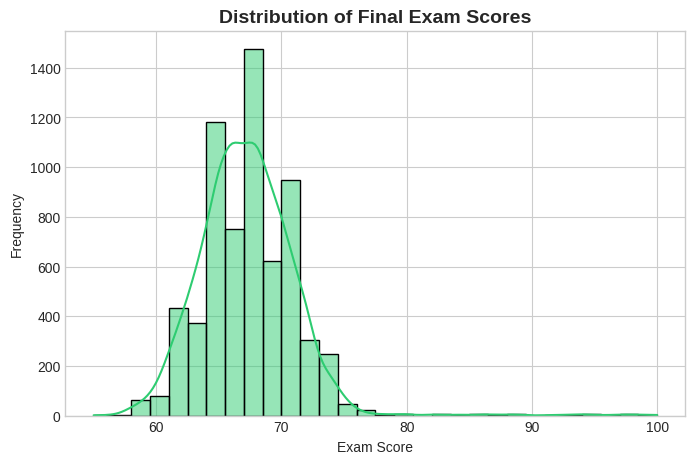

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(df_optimised['Exam_Score'], kde=True, color='#2ecc71', bins=30)
plt.title('Distribution of Final Exam Scores', fontsize=14, fontweight='bold')
plt.xlabel('Exam Score')
plt.ylabel('Frequency')
plt.show()

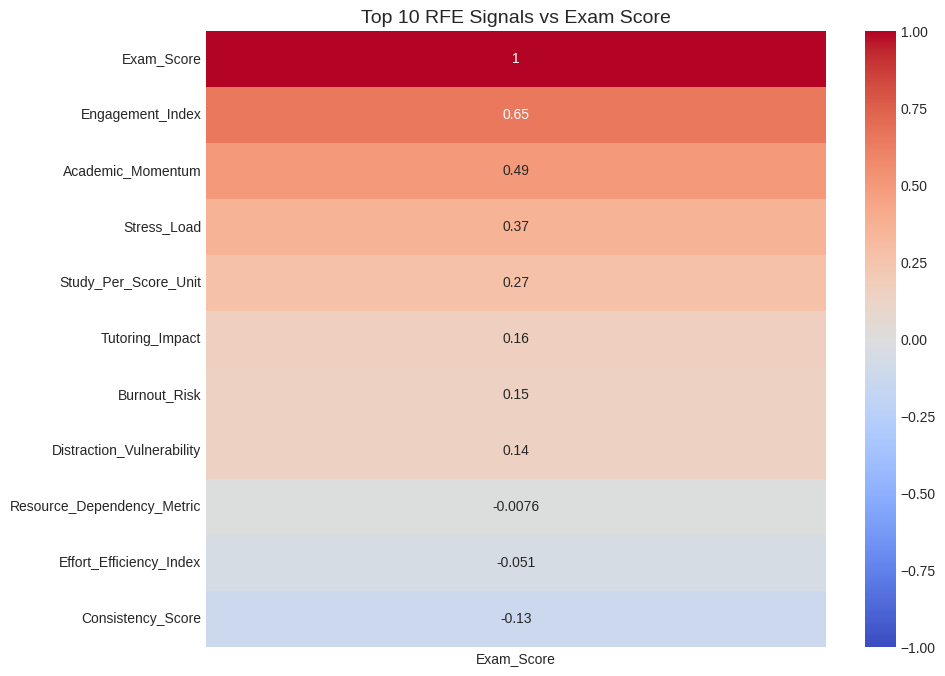

In [22]:
num_opt = df_optimised.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 8))
top_corr = num_opt.corr()[['Exam_Score']].sort_values(by='Exam_Score', ascending=False)
sns.heatmap(top_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Top 10 RFE Signals vs Exam Score', fontsize=14)
plt.show()

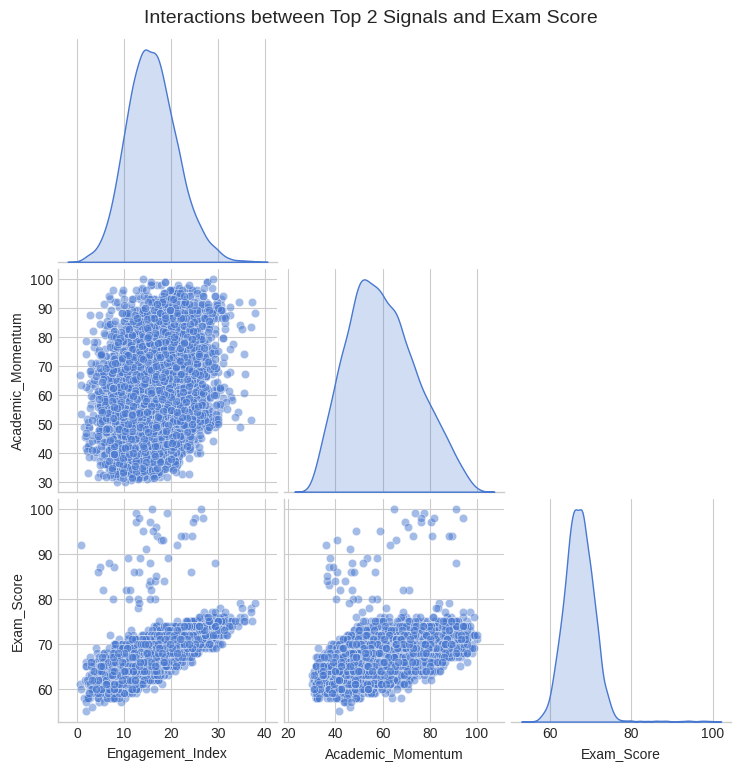

In [23]:
top_2_features = top_corr.index[1:3].tolist()
plot_cols = top_2_features + ['Exam_Score']

sns.pairplot(df_optimised[plot_cols], corner=True, diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Interactions between Top 2 Signals and Exam Score', y=1.02, fontsize=14)
plt.show()

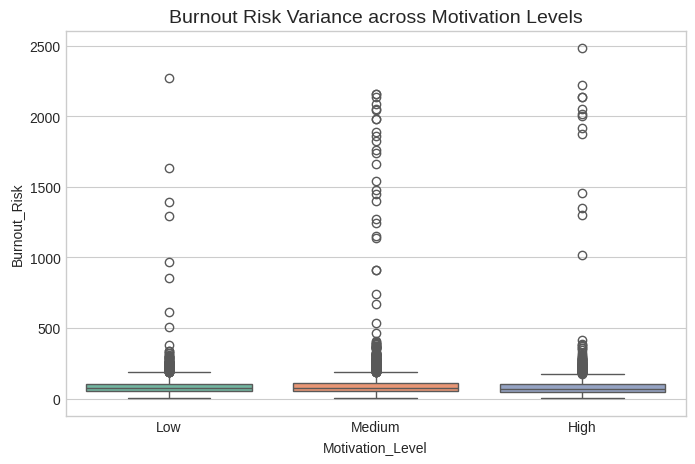

In [24]:
if 'Burnout_Risk' in df_optimised.columns and 'Motivation_Level' in df_optimised.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_optimised, x='Motivation_Level', y='Burnout_Risk', palette='Set2')
    plt.title('Burnout Risk Variance across Motivation Levels', fontsize=14)
    plt.show()

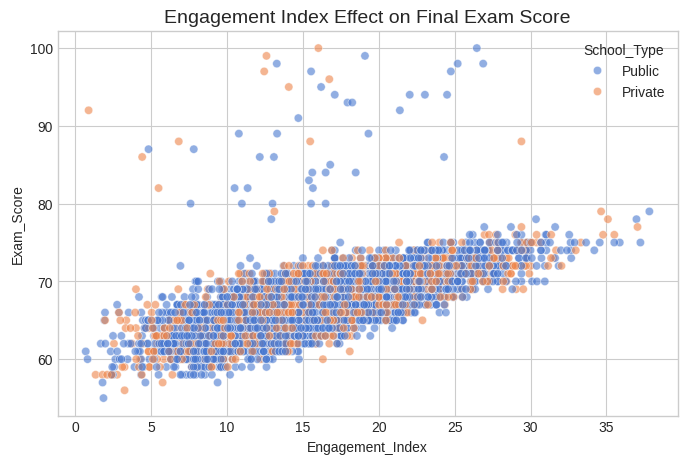

In [25]:
if 'Engagement_Index' in df_optimised.columns and 'School_Type' in df_optimised.columns:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(data=df_optimised, x='Engagement_Index', y='Exam_Score', hue='School_Type', alpha=0.6)
    plt.title('Engagement Index Effect on Final Exam Score', fontsize=14)
    plt.show()

**PHASE 6: Machine Learning Benchmarking**
:
Evaluating Ensembles and standard linear architectures via 5-Fold CV.

In [26]:
y_ml = df_optimised['Exam_Score']
X_ml = df_optimised.drop(columns=['Exam_Score'])

categorical_cols = X_ml.select_dtypes(exclude=[np.number]).columns.tolist()
numerical_cols = X_ml.select_dtypes(include=[np.number]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# We initialize ONE master list to hold ALL models
master_benchmark_results = []
print("Preprocessing pipeline ready. Master benchmark list initialized.")

Preprocessing pipeline ready. Master benchmark list initialized.


In [27]:
print("Training Ensembles (RF, XGBoost, LightGBM, CatBoost)...")

# 1. Standard Ensembles
ensemble_models = {
    "Random Forest": Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))]),
    "XGBoost": Pipeline(steps=[('preprocessor', preprocessor), ('regressor', xgb.XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror'))])
}

for name, pipeline in ensemble_models.items():
    r2_scores, rmse_scores, mae_scores = [], [], []
    for train_idx, test_idx in kf.split(X_ml):
        X_tr, X_te = X_ml.iloc[train_idx], X_ml.iloc[test_idx]
        y_tr, y_te = y_ml.iloc[train_idx], y_ml.iloc[test_idx]
        pipeline.fit(X_tr, y_tr)
        preds = pipeline.predict(X_te)
        r2_scores.append(r2_score(y_te, preds))
        rmse_scores.append(np.sqrt(mean_squared_error(y_te, preds)))
        mae_scores.append(mean_absolute_error(y_te, preds))
    master_benchmark_results.append({'Family': 'Ensemble', 'Model': name, 'R2_Score': np.mean(r2_scores), 'RMSE': np.mean(rmse_scores), 'MAE': np.mean(mae_scores)})

# 2. LightGBM
X_lgb = X_ml.copy()
for col in categorical_cols: X_lgb[col] = X_lgb[col].astype('category')
lgb_r2, lgb_rmse, lgb_mae = [], [], []
for train_idx, test_idx in kf.split(X_lgb):
    X_tr, X_te = X_lgb.iloc[train_idx], X_lgb.iloc[test_idx]
    y_tr, y_te = y_ml.iloc[train_idx], y_ml.iloc[test_idx]
    model = lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1)
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    lgb_r2.append(r2_score(y_te, preds))
    lgb_rmse.append(np.sqrt(mean_squared_error(y_te, preds)))
    lgb_mae.append(mean_absolute_error(y_te, preds))
master_benchmark_results.append({'Family': 'Ensemble', 'Model': 'LightGBM', 'R2_Score': np.mean(lgb_r2), 'RMSE': np.mean(lgb_rmse), 'MAE': np.mean(lgb_mae)})

# 3. CatBoost
cat_r2, cat_rmse, cat_mae = [], [], []
for train_idx, test_idx in kf.split(X_ml):
    X_tr, X_te = X_ml.iloc[train_idx], X_ml.iloc[test_idx]
    y_tr, y_te = y_ml.iloc[train_idx], y_ml.iloc[test_idx]
    model = CatBoostRegressor(iterations=100, cat_features=categorical_cols, random_state=42, verbose=0)
    model.fit(X_tr, y_tr)
    preds = model.predict(X_te)
    cat_r2.append(r2_score(y_te, preds))
    cat_rmse.append(np.sqrt(mean_squared_error(y_te, preds)))
    cat_mae.append(mean_absolute_error(y_te, preds))
master_benchmark_results.append({'Family': 'Ensemble', 'Model': 'CatBoost', 'R2_Score': np.mean(cat_r2), 'RMSE': np.mean(cat_rmse), 'MAE': np.mean(cat_mae)})

print("✅ Ensemble Benchmarking Complete.")

Training Ensembles (RF, XGBoost, LightGBM, CatBoost)...
✅ Ensemble Benchmarking Complete.


In [28]:
print("Training Linear Models (OLS, Ridge, Lasso, ElasticNet, Huber)...")

lin_models = {
    "Standard Linear (OLS)": LinearRegression(),
    "Ridge (L2)": Ridge(alpha=1.0, random_state=42),
    "Lasso (L1)": Lasso(alpha=0.1, random_state=42),
    "ElasticNet (L1+L2)": ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    "Huber (Robust)": HuberRegressor(max_iter=1000)
}

for name, model in lin_models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])

    r2_scores, rmse_scores, mae_scores = [], [], []
    for train_idx, test_idx in kf.split(X_ml):
        X_tr, X_te = X_ml.iloc[train_idx], X_ml.iloc[test_idx]
        y_tr, y_te = y_ml.iloc[train_idx], y_ml.iloc[test_idx]

        pipeline.fit(X_tr, y_tr)
        preds = pipeline.predict(X_te)

        r2_scores.append(r2_score(y_te, preds))
        rmse_scores.append(np.sqrt(mean_squared_error(y_te, preds)))
        mae_scores.append(mean_absolute_error(y_te, preds))

    # Append directly to the exact same master list!
    master_benchmark_results.append({
        'Family': 'Linear', 'Model': name, 'R2_Score': np.mean(r2_scores),
        'RMSE': np.mean(rmse_scores), 'MAE': np.mean(mae_scores)
    })

print("✅ Linear Benchmarking Complete.")

Training Linear Models (OLS, Ridge, Lasso, ElasticNet, Huber)...
✅ Linear Benchmarking Complete.


🏆 UNIFIED MASTER ML BENCHMARK RESULTS 🏆


,Family,Model,R2_Score,RMSE,MAE
0,Linear,Huber (Robust),0.721199,2.037301,0.688829
1,Linear,Ridge (L2),0.719067,2.045322,0.719754
2,Linear,Standard Linear (OLS),0.719061,2.045348,0.719784
3,Ensemble,CatBoost,0.690914,2.151420,0.823847
4,Linear,ElasticNet (L1+L2),0.687329,2.163218,0.948019
5,Ensemble,LightGBM,0.685173,2.171458,0.913598
6,Linear,Lasso (L1),0.661076,2.255155,1.087231
7,Ensemble,XGBoost,0.651996,2.288954,0.998851
8,Ensemble,Random Forest,0.627657,2.369026,1.189267


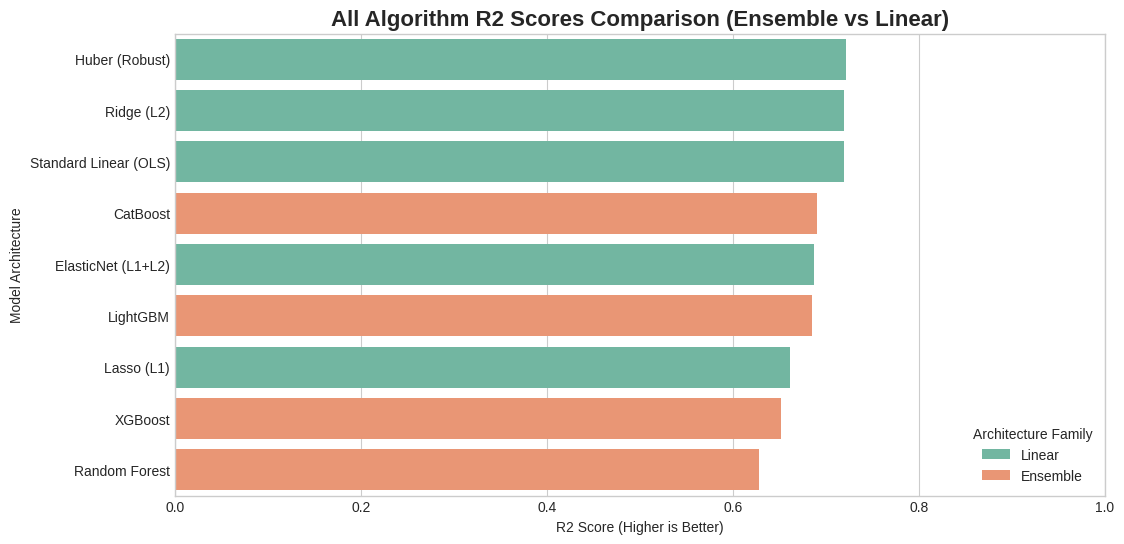

In [29]:
# Convert the master list to a DataFrame and sort by the best R2 score
master_results_df = pd.DataFrame(master_benchmark_results).sort_values(by='R2_Score', ascending=False).reset_index(drop=True)

print("🏆 UNIFIED MASTER ML BENCHMARK RESULTS 🏆")
display(master_results_df)

# Visualizing the unified results
plt.figure(figsize=(12, 6))
sns.barplot(data=master_results_df, x='R2_Score', y='Model', hue='Family', dodge=False, palette='Set2')
plt.title('All Algorithm R2 Scores Comparison (Ensemble vs Linear)', fontsize=16, fontweight='bold')
plt.xlim(0, 1.0)
plt.xlabel('R2 Score (Higher is Better)')
plt.ylabel('Model Architecture')
plt.legend(title='Architecture Family', loc='lower right')
plt.show()

**PHASE 8: K-Means Persona Clustering**

Unsupervised behavioral grouping based on the optimized mathematical features.

In [30]:
features_df = df_optimised.drop(columns=['Exam_Score'], errors='ignore')

numerical_cols_km = features_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_km = features_df.select_dtypes(exclude=[np.number]).columns.tolist()

km_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_km),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_cols_km)
    ])

print("Encoding and scaling data for K-Means...")
X_processed_km = km_preprocessor.fit_transform(features_df)

Encoding and scaling data for K-Means...


In [31]:
print("Running K-Means Clustering (K=4)...")
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_processed_km)

# Exact hardcoded mapping as provided in K_means_clustering.py
persona_mapping = {
    0: "The Disengaged Learner",       # Low Engagement, Low Burnout, Lowest Scores
    1: "The Developing Learner",       # Moderate Engagement, Moderate Scores
    2: "The Overworked Achiever",      # Max Engagement, Max Burnout, High Scores
    3: "The Balanced Achiever"         # High Engagement, Safe Burnout, High Scores
}

final_df = df_optimised.copy()
named_clusters = [persona_mapping[c] for c in clusters]
final_df.insert(0, 'Persona_Cluster', named_clusters)

Running K-Means Clustering (K=4)...


In [32]:
print("\nSUCCESS! 4 Named Personas discovered.")
print("\nFINAL PERSONA PROFILES SUMMARY:")

# Safely compute metrics if they survived RFE
key_metrics = ['Exam_Score', 'Burnout_Risk', 'Engagement_Index']
available_metrics = [m for m in key_metrics if m in final_df.columns]

if available_metrics:
    profile_summary = final_df.groupby('Persona_Cluster')[available_metrics].mean().round(2)
    student_counts = final_df['Persona_Cluster'].value_counts()
    profile_summary.insert(0, 'Total_Students', student_counts)

    print("-" * 75)
    print(profile_summary.to_string())
    print("-" * 75)
else:
    print(final_df['Persona_Cluster'].value_counts())

print("\n✅ End-to-End Execution Complete.")


SUCCESS! 4 Named Personas discovered.

FINAL PERSONA PROFILES SUMMARY:
---------------------------------------------------------------------------
                         Total_Students  Exam_Score  Burnout_Risk  Engagement_Index
Persona_Cluster                                                                    
The Balanced Achiever               609       65.15         47.62              7.95
The Developing Learner             2653       66.92         75.43             14.46
The Disengaged Learner             1964       68.88        153.87             21.05
The Overworked Achiever            1381       66.41         80.37             15.19
---------------------------------------------------------------------------

✅ End-to-End Execution Complete.
